In [1]:
# Utility libraries
import os
import random
from datetime import datetime

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Softmax
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt # For plotting purposes


# Bug still not solved, resort to old keras module (see below)
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Use the above import when the bug is solved
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
# ------------------------------------------#

Using TensorFlow backend.


In [2]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

## MNIST Data Loading and Preprocessing

In [3]:
# Each MNIST image has shape (28,28)
mnist_img_rows, mnist_img_cols = 28, 28
dim_target = 10

# Load the MNIST dataset, which has already been splitted into training and test set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
# Hyper-parameters of the model
learning_rate = 1e-2  # Learning rate
batch_size = 64  # Mini-batch training for stochastic gradient descent
no_epochs = 10  # Maximum number of epochs to train the model

## Construct a Simple Recurrent model

In [12]:
model = Sequential()

# The output of an RNN model has to be a 3D tensor of shape (batch_size, timesteps, features)
model.add(LSTM(input_dim=mnist_img_cols, units=64))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, units), one output per sequence in this case
model.add(Dense(dim_target))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                23808     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 24,458
Trainable params: 24,458
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=optimizers.SGD(lr=learning_rate),  # Optimizer
              # Loss function to minimize
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse will convert categorical labels for us in one-hot form!
              # List of metrics to monitor
              metrics=[metrics.sparse_categorical_accuracy])

## Let's classify MNIST images with an RNN!

In [14]:
# Clear any logs from previous runs
!rm -rf ./logs_rnn

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = os.path.abspath("logs_rnn/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir)

# Chekpoint path for storing our model
checkpoint_path = os.path.abspath("checkpoints/rnn/cp.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Train the Model!
# Note: fit has also the chance to specify a validation split percentage
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback]
                    )

# Fit model on training data
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 14s 293us/sample - loss: 2.2167 - sparse_categorical_accuracy: 0.2027 - val_loss: 2.0695 - val_sparse_categorical_accuracy: 0.2631
Epoch 2/10
48000/48000 [==============================] - 13s 268us/sample - loss: 1.9164 - sparse_categorical_accuracy: 0.3465 - val_loss: 1.7057 - val_sparse_categorical_accuracy: 0.4461
Epoch 3/10
48000/48000 [==============================] - 13s 274us/sample - loss: 1.4583 - sparse_categorical_accuracy: 0.5452 - val_loss: 1.1327 - val_sparse_categorical_accuracy: 0.6474
Epoch 4/10
48000/48000 [==============================] - 13s 279us/sample - loss: 0.9564 - sparse_categorical_accuracy: 0.6950 - val_loss: 0.7754 - val_sparse_categorical_accuracy: 0.7563
Epoch 5/10
48000/48000 [==============================] - 14s 283us/sample - loss: 0.6847 - sparse_categorical_accuracy: 0.7871 - val_loss: 0.5342 - val_sparse_categ

In [15]:
# Visualize your model
%tensorboard --logdir {logdir}

In [16]:
# Add a softmax activation to get probabilities
model.add(Softmax())

Probabilities are ['0.00', '0.24', '0.11', '0.23', '0.02', '0.01', '0.00', '99.10', '0.03', '0.25']
The class that has maximum probability associated to the input is: 7


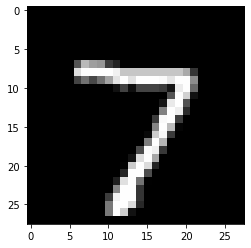

In [17]:
plt.imshow(x_test[0].reshape(mnist_img_rows, mnist_img_cols), cmap='gray')

# Predict output
y = model.predict(np.expand_dims(x_test[0,:, :], 0))[0]

y = [y[i]*100 for i in range(dim_target)]


print(f'Probabilities are {["%.2f" % y[i] for i in range(dim_target)]}')
print(f'The class that has maximum probability associated to the input is: {np.argmax(y)}')